In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import nltk
import collections
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, layers, losses
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from scipy import spatial
import matplotlib.pyplot as plt

## Create Pairs

In [ ]:
def create_pairs(x, y):

  pairs_list = []
  labels_list = []

  for i in range(len(x)):
    for j in range(len(x)):
      if i == j:
        continue;
      if j < i:
        continue;
      pairs_list.append((x[i], x[j]))
      labels_list.append((y[i][0], y[j][0]))

  return np.array(pairs_list), np.array(labels_list)

In [ ]:
# x_train_pairs, y_train_labels = create_pairs(X_train, y_train)
# x_test_pairs, y_test_labels = create_pairs(X_test, y_test)

In [ ]:
# x_train_pairs.shape

In [ ]:
# y_test_labels.shape

In [ ]:
# y_test_labels = np.where(y_test_labels[:,0] == y_test_labels[:,1], 0, 1)
# y_test_labels.sum() / len(y_test_labels)

## BERT

In [ ]:
!pip install spacy-sentence-bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import spacy_sentence_bert
import spacy

In [ ]:
nlp = spacy_sentence_bert.load_model('en_stsb_roberta_large')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/NLP_Projekt/IMDB Dataset.csv").iloc[:1000,:]
y = np.asarray(df.iloc[:,1])
y[y=="positive"] = 1
y[y=="negative"] = 0
y = y.reshape(-1,1).astype('float32')
X = np.array([nlp(df.iloc[i,0]).vector for i in range(df.shape[0])])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=123)
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train.shape

(150, 1024)

In [ ]:
y_test.mean()

0.5047059

In [ ]:
y = np.asarray(df.iloc[:,1])
y[y=="positive"] = 1
y[y=="negative"] = 0
y = y.reshape(-1,1).astype('float32')

x_train_pairs, y_train_labels = create_pairs(X_train, y_train)
x_test_pairs, y_test_labels = create_pairs(X_test, y_test)

In [ ]:
# if labels are the same -> label 0
# if labels are not the same -> label 1
y_train_labels = np.where(y_train_labels[:,0] == y_train_labels[:,1], 0, 1)
y_train_labels

array([0, 0, 0, ..., 1, 1, 0])

In [ ]:
x_train_pairs[0,0,:]

array([-0.56274474,  1.7482975 ,  0.24755761, ...,  0.542841  ,
       -0.49901325,  0.5347668 ], dtype=float32)

In [ ]:
x_train_pairs[0,1,:]

array([ 0.10277322,  1.0163211 ,  0.64752185, ...,  0.33892736,
       -1.4311101 ,  1.7867584 ], dtype=float32)

In [ ]:
# https://keras.io/examples/vision/siamese_contrastive/
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))

len_bag = x_train_pairs.shape[2]

def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    x = tf.math.l2_normalize(x)
    y = tf.math.l2_normalize(y)
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    output = tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))
    return output

def cosine_sim(vects):
    x, y = vects
    x = tf.math.l2_normalize(x)
    y = tf.math.l2_normalize(y)

    return tf.multiply(x,y)

def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):

        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """


        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        # return tf.math.reduce_mean(
        #     (1 - y_true) * square_pred + (y_true) * margin_square
        # )

        return tfa.losses.contrastive_loss(y_true, square_pred, margin=0.5)

    return contrastive_loss



input = layers.Input((len_bag,))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Dense(512)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256)(x)
x = layers.Dense(128)(x)
x = layers.Dense(32)(x)

embedding_network = tf.keras.Model(input, x)


input_1 = layers.Input((len_bag,))
input_2 = layers.Input((len_bag,))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [ ]:
siamese.compile(loss=loss(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=["accuracy"], run_eagerly=True)
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 model (Functional)             (None, 32)           697248      ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

In [ ]:
x_train_1 = x_train_pairs[:,0,:]
x_train_2 = x_train_pairs[:,1,:]

x_test_1 = x_test_pairs[:,0,:]
x_test_2 = x_test_pairs[:,1,:]

x_train_1 = tf.convert_to_tensor(x_train_1)
x_train_2 = tf.convert_to_tensor(x_train_2)

x_test_1 = tf.convert_to_tensor(x_test_1)
x_test_2 = tf.convert_to_tensor(x_test_2)

y_train_labels = tf.convert_to_tensor(y_train_labels)
y_test_labels = tf.convert_to_tensor(y_test_labels)


y_train_labels = tf.cast(y_train_labels, tf.float32)
y_test_labels = tf.cast(y_test_labels, tf.float32)

x_test_1 = tf.cast(x_test_1, tf.float32)
x_test_2 = tf.cast(x_test_2, tf.float32)

x_train_1 = tf.cast(x_train_1, tf.float32)
x_train_2 = tf.cast(x_train_2, tf.float32)

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

history = siamese.fit(
    [x_train_1, x_train_2],
    y_train_labels,
    validation_data=([x_test_1, x_test_2], y_test_labels),
    batch_size=128,
    epochs=10
)


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
88/88 [==============================] - ETA: 0s - loss: 0.0625 - accuracy: 0.4497

KeyboardInterrupt: ignored

In [ ]:
a = siamese.predict([x_test_1, x_test_2])

155/155 [==============================] - 3s 20ms/step


In [ ]:
y_test_labels.numpy()

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
results = pd.DataFrame(a)
results["true"] = y_test_labels[:,1]
results.iloc[:50,:]

,0,true
0,0.669403,0.0
1,0.820470,0.0
2,0.825707,0.0
3,0.728253,0.0
4,0.754589,0.0
5,0.732197,0.0
6,0.792361,1.0
7,0.772184,0.0
8,0.772211,0.0
9,0.769055,0.0


In [ ]:
import matplotlib.pyplot as plt

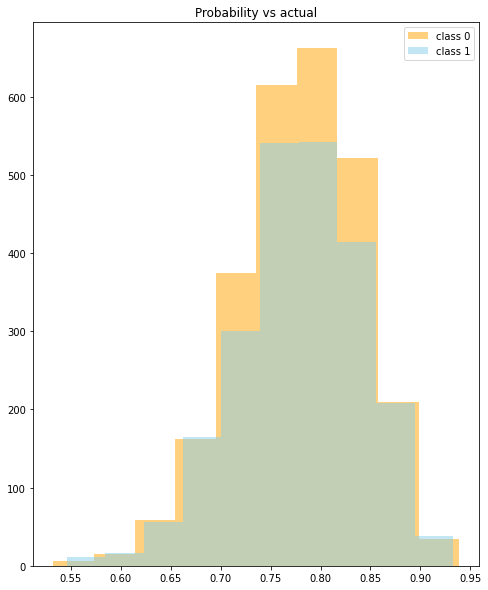

In [ ]:
plt.figure(figsize=(8,10))
plt.hist(results[results["true"] == 0][0], color="orange", alpha = 0.5)
plt.hist(results[results["true"] == 1][0], color="skyblue", alpha = 0.5)
plt.legend(["class 0", "class 1"])
plt.title("Probability vs actual")
plt.show()

In [ ]:
preds = []

for i in range(len(X_test)):
    pairs_list = []

    for j in range(len(X_train)):
        pairs_list.append((X_test[i], X_train[j]))

    pairs_list = np.array(pairs_list)

    b = siamese.predict([pairs_list[:,0,:], pairs_list[:,1,:]])
    preds.append(int(b[np.where(y_train.flatten() == 0)].mean() < b[np.where(y_train.flatten() == 1)].mean()))

4/4 [==============================] - 0s 15ms/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


4/4 [==============================] - 0s 18ms/step


In [ ]:
np.mean(y_test.flatten()==preds)

0.55

## BERT + CV 

In [ ]:
# https://keras.io/examples/vision/siamese_contrastive/
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    x = tf.math.l2_normalize(x)
    y = tf.math.l2_normalize(y)
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    output = tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))
    return output

def cosine_sim(vects):
    x, y = vects
    x = tf.math.l2_normalize(x)
    y = tf.math.l2_normalize(y)

    return tf.multiply(x,y)

def loss(margin=0.5):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):

        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """


        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

        # return tfa.losses.contrastive_loss(y_true, square_pred, margin=0.5)

    return contrastive_loss


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 model_10 (Functional)          (None, 32)           4902304     ['input_17[0][0]',               
                                                                  'input_18[0][0]']               
                                                                                                  
 lambda_5 (Lambda)              (None, 32)           0           ['model_10[0][0]',        

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


155/155 [==============================] - 14s 92ms/step - loss: 0.1281 - accuracy: 0.5026
Epoch 2/5
155/155 [==============================] - 14s 91ms/step - loss: 0.1251 - accuracy: 0.6002
Epoch 3/5
155/155 [==============================] - 14s 93ms/step - loss: 0.1198 - accuracy: 0.7307
Epoch 4/5
155/155 [==============================] - 14s 91ms/step - loss: 0.1143 - accuracy: 0.8055
Epoch 5/5
155/155 [==============================] - 3s 20ms/step


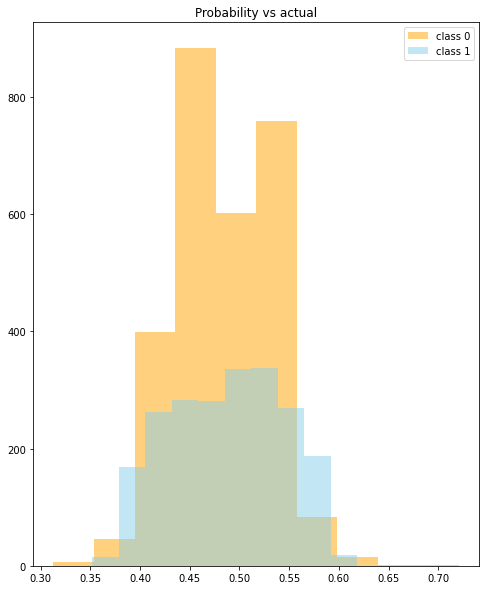

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
4/4 [==============================] - 0s 29ms/step
Accuracy:
0.7783333333333333
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 input_21 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 model_12 (Functional)          (None, 32)           4902304     ['input_20[0][0]',               
                                                                  'input_21[0][0]']               
                                            

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


155/155 [==============================] - 14s 92ms/step - loss: 0.1240 - accuracy: 0.5172
Epoch 2/5
155/155 [==============================] - 15s 99ms/step - loss: 0.1204 - accuracy: 0.6127
Epoch 3/5
155/155 [==============================] - 14s 92ms/step - loss: 0.1132 - accuracy: 0.7446
Epoch 4/5
155/155 [==============================] - 14s 91ms/step - loss: 0.1062 - accuracy: 0.8287
Epoch 5/5
155/155 [==============================] - 3s 20ms/step


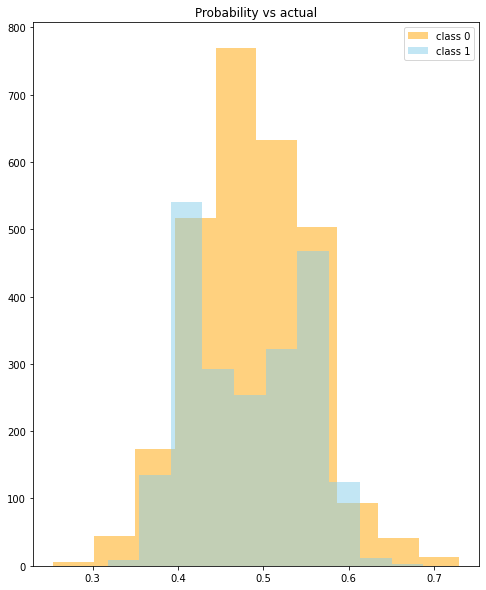

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
4/4 [==============================] - 0s 28ms/step
Accuracy:
0.779
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 model_14 (Functional)          (None, 32)           4902304     ['input_23[0][0]',               
                                                                  'input_24[0][0]']               
                                                         

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


155/155 [==============================] - 15s 95ms/step - loss: 0.1242 - accuracy: 0.5586
Epoch 2/5
155/155 [==============================] - 14s 93ms/step - loss: 0.1171 - accuracy: 0.7505
Epoch 3/5
155/155 [==============================] - 15s 94ms/step - loss: 0.1101 - accuracy: 0.8283
Epoch 4/5
155/155 [==============================] - 14s 93ms/step - loss: 0.1043 - accuracy: 0.8917
Epoch 5/5
155/155 [==============================] - 3s 21ms/step


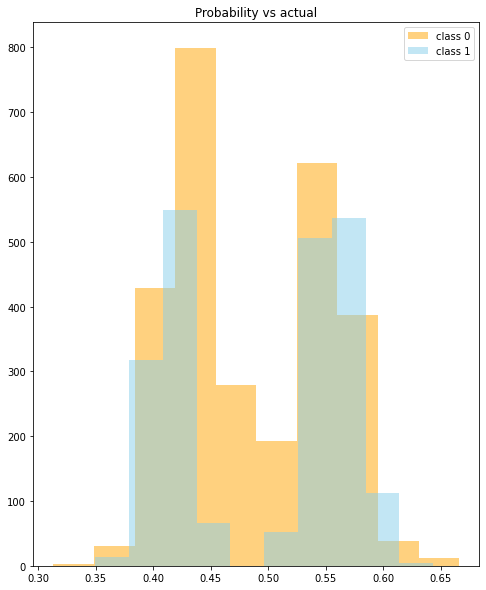

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
4/4 [==============================] - 0s 30ms/step
Accuracy:
0.7616666666666667
Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 model_16 (Functional)          (None, 32)           4902304     ['input_26[0][0]',               
                                                                  'input_27[0][0]']               
                                            

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


155/155 [==============================] - 15s 95ms/step - loss: 0.1271 - accuracy: 0.5097
Epoch 2/5
155/155 [==============================] - 15s 94ms/step - loss: 0.1232 - accuracy: 0.6683
Epoch 3/5
155/155 [==============================] - 15s 97ms/step - loss: 0.1165 - accuracy: 0.8113
Epoch 4/5
155/155 [==============================] - 15s 94ms/step - loss: 0.1096 - accuracy: 0.8937
Epoch 5/5
155/155 [==============================] - 3s 22ms/step


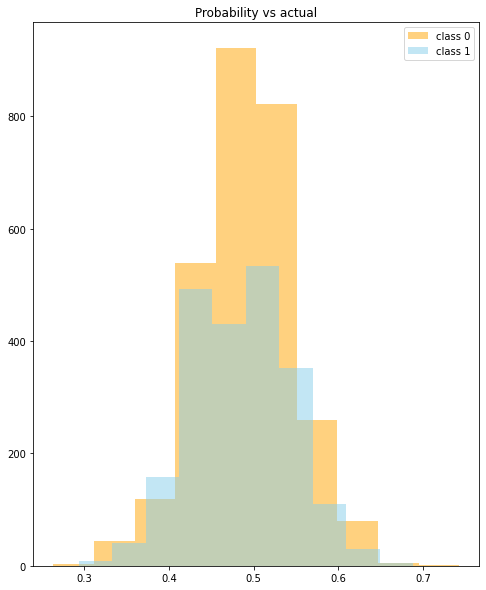

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
4/4 [==============================] - 0s 28ms/step
Accuracy:
0.7644444444444445


In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import f1_score

df = pd.read_csv("/content/drive/MyDrive/NLP_Projekt/IMDB Dataset.csv").iloc[:200,:]
y = np.asarray(df.iloc[:,1])
y[y=="positive"] = 1
y[y=="negative"] = 0
y = y.reshape(-1,1).astype('float32')
X = np.array([nlp(df.iloc[i,0]).vector for i in range(df.shape[0])])

skf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=123)
skf.get_n_splits(X, y)

accuracy_list = []
f1_score_list = []

for train_index, test_index in skf.split(X, y):

  # Select random subsamples
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  X_train = np.array(X_train)
  X_test = np.array(X_test)
  X_train.shape

  df2 = pd.read_csv("/content/drive/MyDrive/NLP_Projekt/IMDB Dataset.csv").iloc[200:9200,:]
  y_test = np.asarray(df2.iloc[:,1])
  y_test[y_test=="positive"] = 1
  y_test[y_test=="negative"] = 0
  y_test = y_test.reshape(-1,1).astype('float32')
  X_test = np.array([nlp(df2.iloc[i,0]).vector for i in range(df2.shape[0])])
  X_test = np.array(X_test)



  # create pairs
  x_train_pairs, y_train_labels = create_pairs(X_train, y_train)
  # x_test_pairs, y_test_labels = create_pairs(X_test, y_test)
  # if labels are the same -> label 0
  # if labels are not the same -> label 1
  y_train_labels = np.where(y_train_labels[:,0] == y_train_labels[:,1], 0, 1)

  # https://keras.io/examples/vision/siamese_contrastive/
  # Provided two tensors t1 and t2
  # Euclidean distance = sqrt(sum(square(t1-t2)))

  len_bag = x_train_pairs.shape[2]

  input = layers.Input((len_bag,))
  x = tf.keras.layers.BatchNormalization()(input)
  x = layers.Dense(2048)(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(1024)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(512)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(256)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(128)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(32)(x)

  embedding_network = tf.keras.Model(input, x)


  input_1 = layers.Input((len_bag,))
  input_2 = layers.Input((len_bag,))

  # As mentioned above, Siamese Network share weights between
  # tower networks (sister networks). To allow this, we will use
  # same embedding network for both tower networks.
  tower_1 = embedding_network(input_1)
  tower_2 = embedding_network(input_2)

  merge_layer = layers.Lambda(cosine_sim)([tower_1, tower_2])
  normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
  output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
  siamese = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)

  siamese.compile(loss=loss(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=["accuracy"], run_eagerly=True)
  siamese.summary()

  x_train_1 = x_train_pairs[:,0,:]
  x_train_2 = x_train_pairs[:,1,:]

  # x_test_1 = x_test_pairs[:,0,:]
  # x_test_2 = x_test_pairs[:,1,:]

  x_train_1 = tf.convert_to_tensor(x_train_1)
  x_train_2 = tf.convert_to_tensor(x_train_2)

  # x_test_1 = tf.convert_to_tensor(x_test_1)
  # x_test_2 = tf.convert_to_tensor(x_test_2)

  y_train_labels = tf.convert_to_tensor(y_train_labels)
  # y_test_labels = tf.convert_to_tensor(y_test_labels)


  y_train_labels = tf.cast(y_train_labels, tf.float32)
  # y_test_labels = tf.cast(y_test_labels, tf.float32)

  # x_test_1 = tf.cast(x_test_1, tf.float32)
  # x_test_2 = tf.cast(x_test_2, tf.float32)

  x_train_1 = tf.cast(x_train_1, tf.float32)
  x_train_2 = tf.cast(x_train_2, tf.float32)


  history = siamese.fit(
      [x_train_1, x_train_2],
      y_train_labels,
      batch_size=32,
      epochs=5
  )

  # a = siamese.predict([x_test_1, x_test_2])
  # results = pd.DataFrame(a)
  # results["true"] = y_test_labels[:,1]
  # results.iloc[:50,:]

  # plt.figure(figsize=(8,10))
  # plt.hist(results[results["true"] == 0][0], color="orange", alpha = 0.5)
  # plt.hist(results[results["true"] == 1][0], color="skyblue", alpha = 0.5)
  # plt.legend(["class 0", "class 1"])
  # plt.title("Probability vs actual")
  # plt.show()

  preds = []

  for i in range(len(X_test)):
      pairs_list = []

      for j in range(len(X_train)):
          pairs_list.append((X_test[i], X_train[j]))

      pairs_list = np.array(pairs_list)

      b = siamese.predict([pairs_list[:,0,:], pairs_list[:,1,:]])
      preds.append(int(b[np.where(y_train.flatten() == 0)].mean() > b[np.where(y_train.flatten() == 1)].mean()))

  accuracy_list.append(np.mean(y_test.flatten()==preds))
  print("Accuracy:")
  print(np.mean(y_test.flatten()==preds))
  f1_score_list.append(f1_score(y_test.flatten(), preds))


In [ ]:
accuracy_list

[0.7783333333333333, 0.779, 0.7616666666666667, 0.7644444444444445]

In [ ]:
f1_score_list

[0.7835990888382688,
 0.7805846662989521,
 0.7527947447274405,
 0.7791666666666667]